Index(['COUNT', 'Normalized Count%', '104. TOTAL RELEASES'], dtype='object')


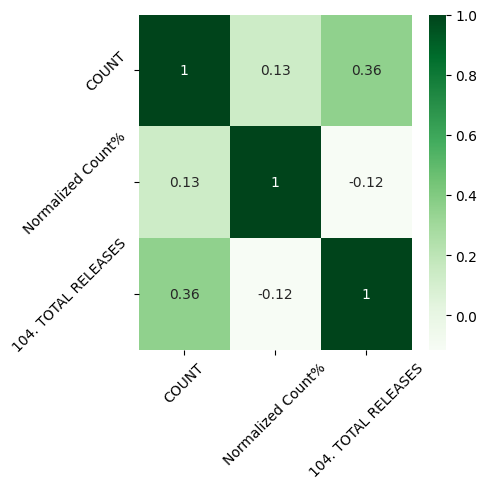

South


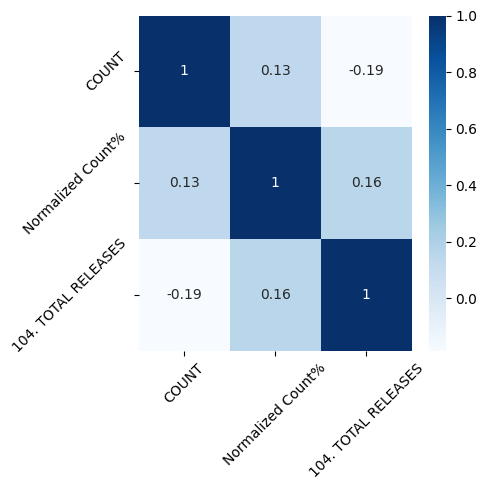

Alaska and Hawaii


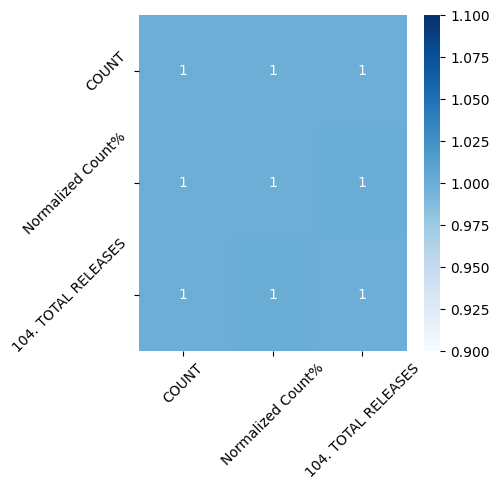

Southwest


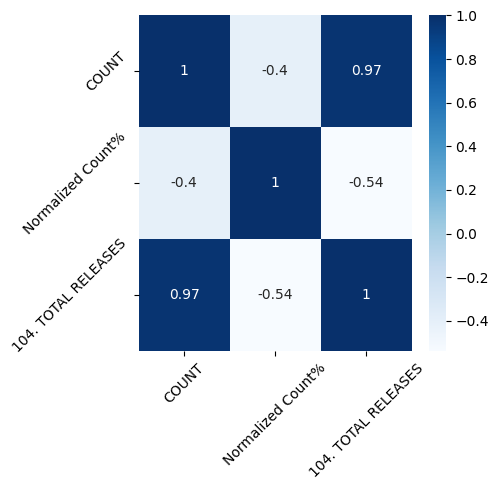

West Coast


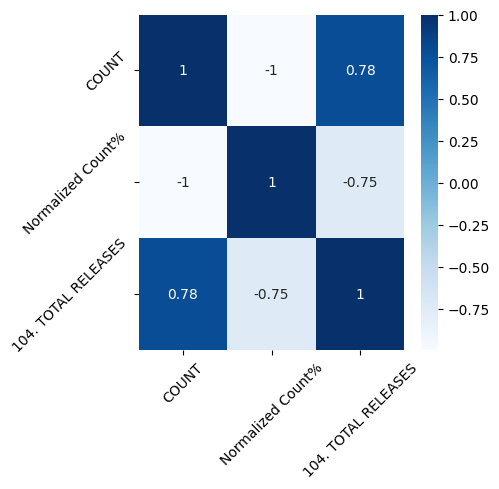

Rocky Mountains


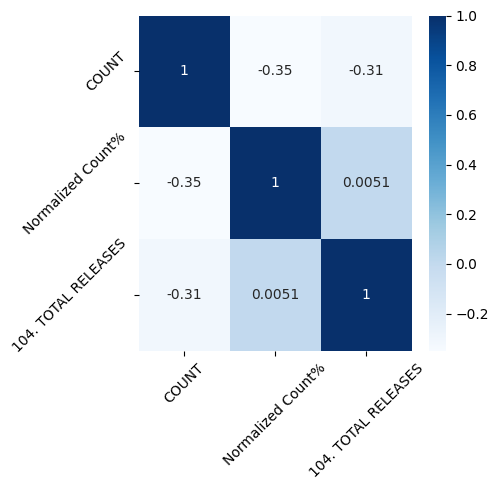

New England


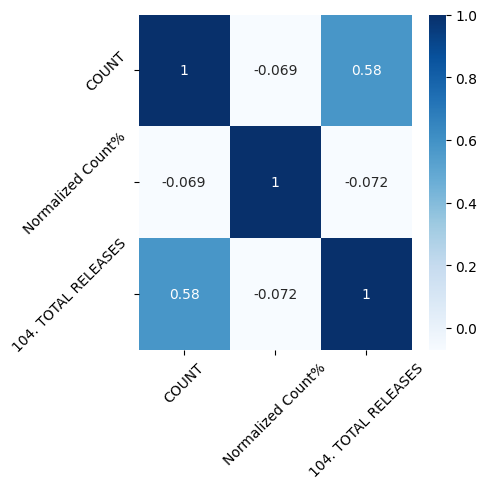

Mid-Atlantic


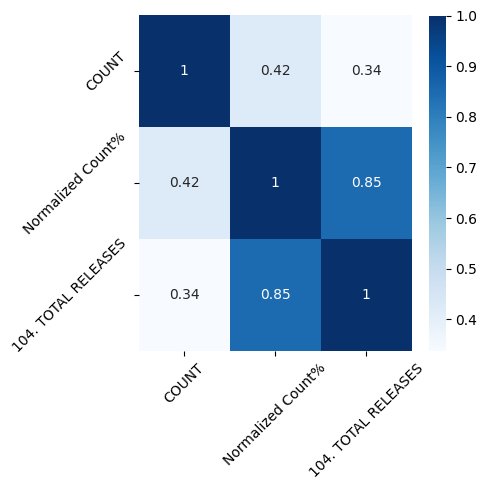

Midwest


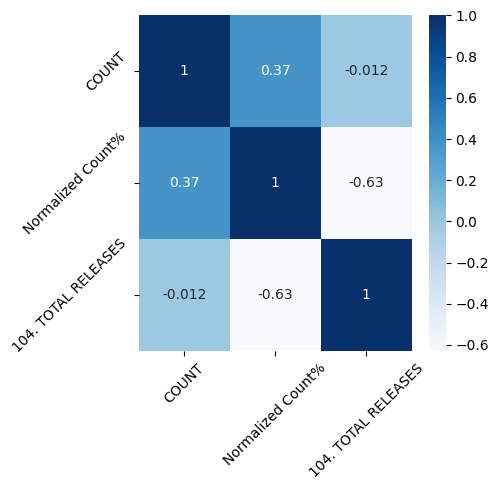

Great Plains


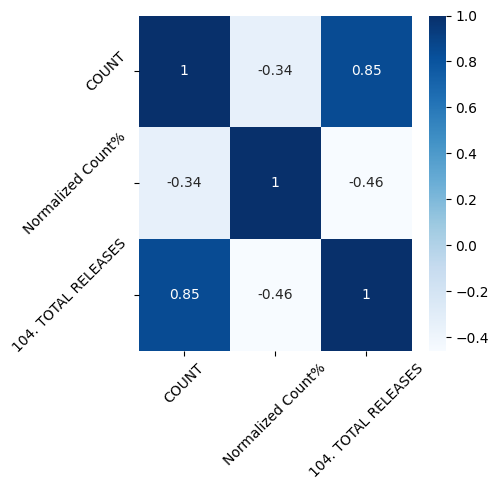

In [53]:
#importing modules
import pandas as pd
import csv
import seaborn as sns 
import matplotlib.pyplot as plt


#remove warnings
pd.set_option('mode.chained_assignment', None)

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION
data_path_chemicalpollution = '/kaggle/input/2018-chemical-pollutant-data/2018_us.csv'
data_path_states ='/kaggle/input/50-states-abbreviations/50States.csv'
data_path_cancercount = '/kaggle/input/cancer-by-area/BYAREA.csv.TXT'
data_path_differentRegions = '/kaggle/input/regions-to-state-mapping-usa/DifferentRegionsUSA.csv'
data_path_allsites = '/kaggle/input/all-cancer-sites/sites.csv'

year = '2018'
pollutant = 'Benzene'
#site_csv = 'df_cancer_leadpollution-brainandothernervoussystem.csv'

site = 'Pancreas' 
num1 = 0
num2 = 1000

########################################################
#STEP 1 - Create Chemical pollution dataset for USA states
########################################################
#converting into dataframe
df_cp = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_chemicalpollution))))

#get required columns
#print(len(df_cp.index))
#print(len(df_cp.columns))
#print((df_cp.columns))
chemical_pollution_df = df_cp.iloc[:, [7,33,42, 61, 84, 103, 104, 115]]
#print(chemical_pollution_df.columns)
chemical_pollution_df = chemical_pollution_df.loc[(chemical_pollution_df['34. CHEMICAL'] == pollutant)] 
#chemical_pollution_df = chemical_pollution_df.loc[(chemical_pollution_df['43. CARCINOGEN'] == 'YES') & (chemical_pollution_df['34. CHEMICAL'] == pollutant)] 

#print(len(chemical_pollution_df.index))

chemical_pollution_df['62. ON-SITE RELEASE TOTAL'] = chemical_pollution_df['62. ON-SITE RELEASE TOTAL'].astype('float')
chemical_pollution_df['85. OFF-SITE RELEASE TOTAL'] = chemical_pollution_df['85. OFF-SITE RELEASE TOTAL'].astype('float')
chemical_pollution_df['104. TOTAL RELEASES'] = chemical_pollution_df['104. TOTAL RELEASES'].astype('float')
chemical_pollution_df['105. 8.1 - RELEASES'] = chemical_pollution_df['105. 8.1 - RELEASES'].astype('float')
chemical_pollution_df['116. PRODUCTION WSTE (8.1-8.7)'] = chemical_pollution_df['116. PRODUCTION WSTE (8.1-8.7)'].astype('float')
#print(chemical_pollution_df.head)

chemical_pollution_df_new = chemical_pollution_df.iloc[:,[0,3,4,5,6,7]]
#print(chemical_pollution_df_new.head)
#print(chemical_pollution_df_new.columns)
chemical_pollution_df_final = chemical_pollution_df_new.groupby(['8. ST'], as_index=False).sum()
chemical_pollution_df_final = chemical_pollution_df_final.iloc[:,[0,1,2,3,4]]
chemical_pollution_df_final.rename(columns = {'8. ST':'AREA_abbr'}, inplace=True)

#print(chemical_pollution_df_final.columns)
#print(len(chemical_pollution_df_final.columns))
#print(chemical_pollution_df_final.head(1))
#print(chemical_pollution_df_final)
#print(len(chemical_pollution_df_final.index))

########################################################
#STEP 2 - Expanding the abbreviation of states
########################################################
df_states = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_states))))
df_states_final = df_states.iloc[:, [0,1]]
df_states_final.rename(columns = {'Abbr':'AREA_abbr'}, inplace=True)
df_states_final.rename(columns = {'State':'AREA'}, inplace=True)
df_states_final['AREA'] = df_states_final['AREA'].str.lower()
#print(df_states_final.columns)
#print(df_states_final)
df_all_cps = pd.merge(chemical_pollution_df_final, df_states_final, on='AREA_abbr', how='inner')
#print (df_all_cps)


########################################################
#STEP 3 - Create Cancer count dataset for USA states
##########################################################
#create dataframe
df_cc = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_cancercount))))

#Splitting the data into columns
df_new = df_cc.iloc[:, [0]]
df_new[['AREA','AGE_ADJUSTED_CI_LOWER', 'AGE_ADJUSTED_CI_UPPER','AGE_ADJUSTED_RATE','COUNT','EVENT_TYPE','POPULATION','RACE','SEX','SITE','YEAR','CRUDE_CI_LOWER','CRUDE_CI_UPPER','CRUDE_RATE']] = df_new['AREA|AGE_ADJUSTED_CI_LOWER|AGE_ADJUSTED_CI_UPPER|AGE_ADJUSTED_RATE|COUNT|EVENT_TYPE|POPULATION|RACE|SEX|SITE|YEAR|CRUDE_CI_LOWER|CRUDE_CI_UPPER|CRUDE_RATE'].str.split('|', expand=True)

#Clean the data to remove the rows where the values are not integers
if (site == 'all'):
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == 'All Cancer Sites Combined') & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 
else:
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == site) & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 

# #Seleting the columns needed
cancer_area = df_new.iloc[:, [1,5]]

# #Converting column to integer
#print(len(df_new))
cancer_area['COUNT'] = cancer_area['COUNT'].astype('int')
#print(cancer_area) 

########################################################
#STEP 4- Create dataset population per state
##########################################################
#Selecting the columns needed
cancer_area_population = df_new.iloc[:, [1,7]]

#Converting column to integer
cancer_area_population['POPULATION'] = cancer_area_population['POPULATION'].astype('int')
cancer_area_population = cancer_area_population.groupby(['AREA'], as_index=False).max()

########################################################
#STEP 5 - Merge datasets cancer_area_pollution, cancer_count, chemical_pollution_df_new
##########################################################
df_cancer_population_count = pd.merge(cancer_area, cancer_area_population, on='AREA', how='outer')

#Create additional column in the table for (Count/Population * 10000)
df_cancer_population_count['COUNT'] = df_cancer_population_count['COUNT'].astype('int')
df_cancer_population_count['POPULATION'] = df_cancer_population_count['POPULATION'].astype('int')
df_cancer_population_count['Normalized Count%'] = df_cancer_population_count['COUNT'] * 10000 / df_cancer_population_count['POPULATION']

df_cancer_population_count['AREA'] =  df_cancer_population_count['AREA'].str.lower()
#print (df_cancer_population_count)
#print (df_all_cps)

df_all = pd.merge(df_cancer_population_count, df_all_cps, on='AREA', how='inner')
#print(df_all)

########################################################
#STEP 6 - Check for correlation across USA
##########################################################
df_region_cancer = df_all.iloc[:,[1,3,7]]
print(df_region_cancer.columns)
matrix_normalized_test = df_region_cancer.corr()
#print (matrix_normalized_test)
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True
fig, (ax1) = plt.subplots(ncols=1)
fig.subplots_adjust(wspace=0.05)
sns.heatmap(matrix_normalized_test, cmap="Greens", ax=ax1, cbar=True, annot=True)
ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
fig.subplots_adjust(wspace=0.005)
plt.show()

########################################################
#STEP 6 - Add in different regions to meged table
##########################################################
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_differentRegions))))
df_ap['AREA'] =  df_ap['AREA'].str.lower()
df_cancercount_region = pd.merge(df_all, df_ap, on='AREA', how='outer' )
#print(df_cancercount_region)

########################################################
#STEP 7 - Check for correlation across different regions
##########################################################
regions = ["South","Alaska and Hawaii", "Southwest", "West Coast", "Rocky Mountains", "New England", "Mid-Atlantic", "Midwest", "Great Plains"]
for region in regions:
    #---Consider region create corelation matrix ----
    df_region = df_cancercount_region.loc[(df_cancercount_region['Region '] == region)] 
    print (region)
    df_region_cancer = df_region.iloc[:, [1,3,7]]
    #print (df_region_cancer)
    matrix_normalized_test = df_region_cancer.corr()
    plt.rcParams["figure.figsize"] = [5, 5]
    plt.rcParams["figure.autolayout"] = True
    fig, (ax1) = plt.subplots(ncols=1)
    sns.heatmap(matrix_normalized_test, cmap="Blues", ax=ax1, cbar=True, annot=True)
    ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
    ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
    fig.subplots_adjust(wspace=0.005)
    plt.show()

# ########################## METHOD END ################################



Index(['COUNT', 'Normalized Count%', '104. TOTAL RELEASES'], dtype='object')


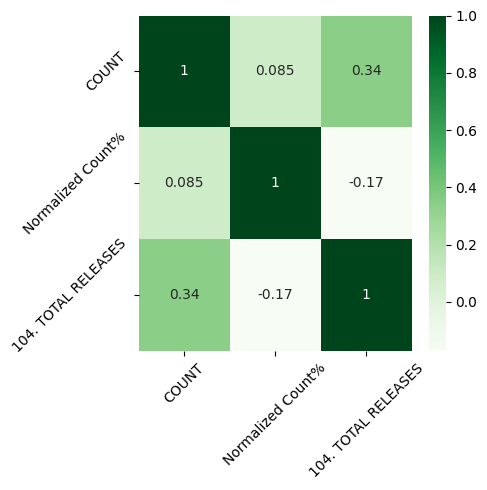

South


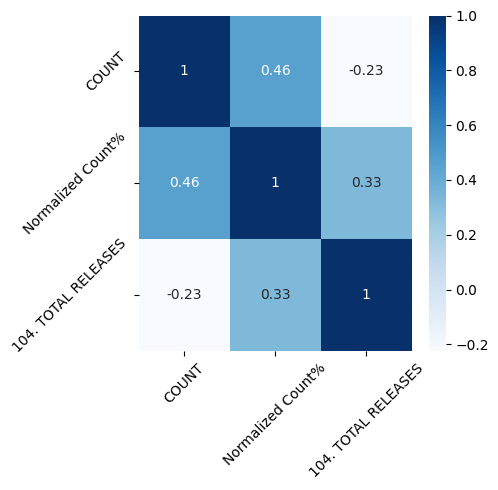

Alaska and Hawaii


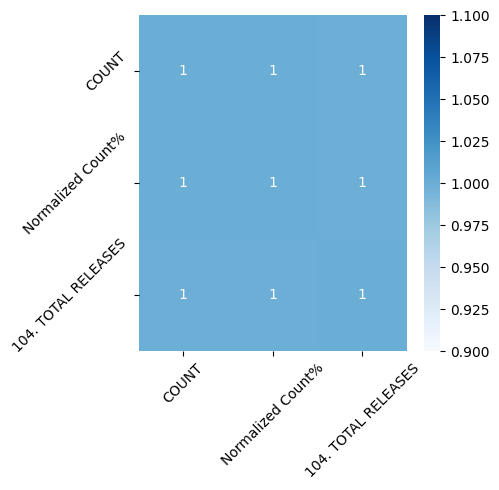

Southwest


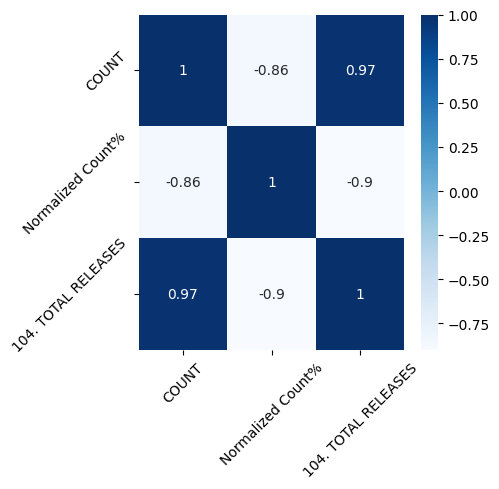

West Coast


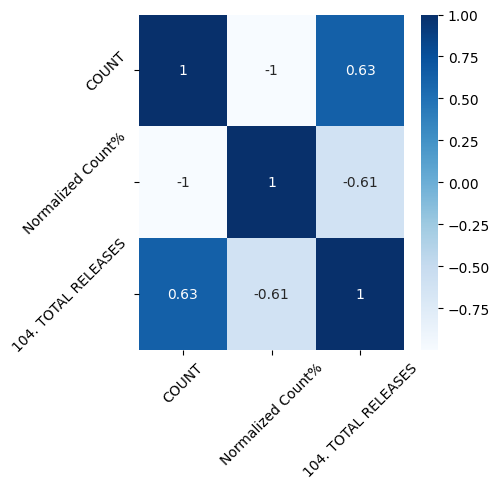

Rocky Mountains


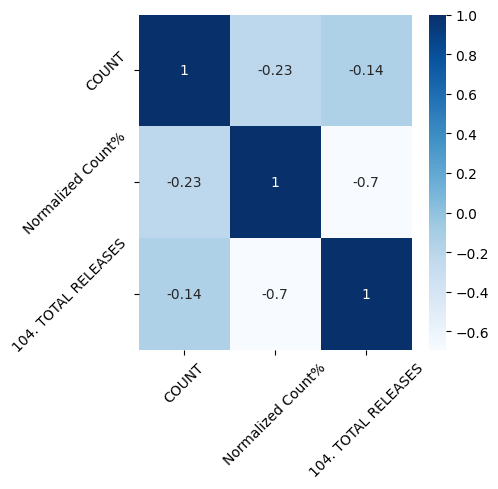

New England


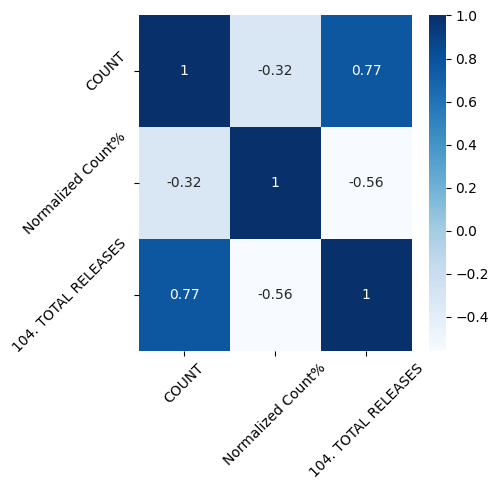

Mid-Atlantic


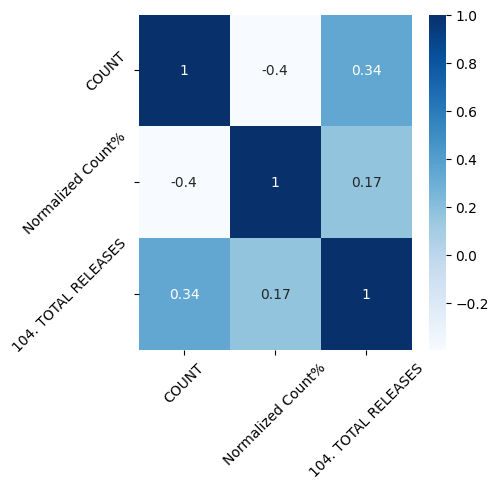

Midwest


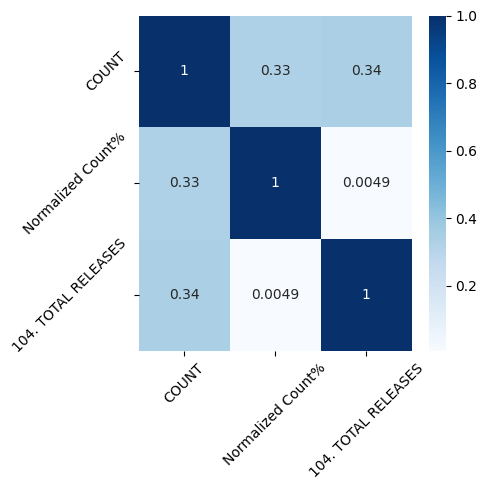

Great Plains


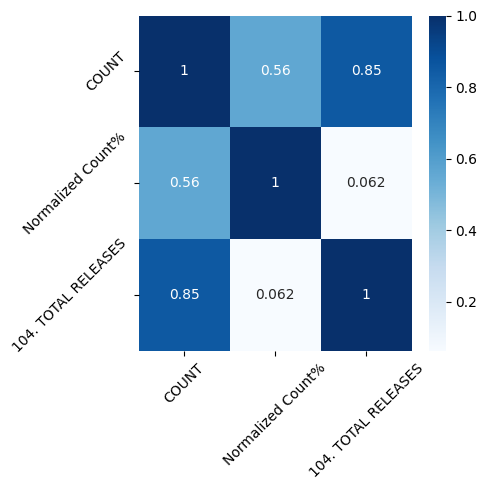

In [54]:
#importing modules
import pandas as pd
import csv
import seaborn as sns 
import matplotlib.pyplot as plt


#remove warnings
pd.set_option('mode.chained_assignment', None)

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION
data_path_chemicalpollution = '/kaggle/input/2019-chemical-dataset/2019_us.csv'
data_path_states ='/kaggle/input/50-states-abbreviations/50States.csv'
data_path_cancercount = '/kaggle/input/cancer-by-area/BYAREA.csv.TXT'
data_path_differentRegions = '/kaggle/input/regions-to-state-mapping-usa/DifferentRegionsUSA.csv'
data_path_allsites = '/kaggle/input/all-cancer-sites/sites.csv'

year = '2019'
pollutant = 'Benzene'
#site_csv = 'df_cancer_leadpollution-brainandothernervoussystem.csv'

site = 'Pancreas' 
num1 = 0
num2 = 1000

########################################################
#STEP 1 - Create Chemical pollution dataset for USA states
########################################################
#converting into dataframe
df_cp = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_chemicalpollution))))

#get required columns
#print(len(df_cp.index))
#print(len(df_cp.columns))
#print((df_cp.columns))
chemical_pollution_df = df_cp.iloc[:, [7,33,42, 61, 84, 103, 104, 115]]
#print(chemical_pollution_df.columns)
#chemical_pollution_df = chemical_pollution_df.loc[(chemical_pollution_df['43. CARCINOGEN'] == 'YES') & (chemical_pollution_df['34. CHEMICAL'] == pollutant)] 
chemical_pollution_df = chemical_pollution_df.loc[(chemical_pollution_df['34. CHEMICAL'] == pollutant)] 
#print(len(chemical_pollution_df.index))


chemical_pollution_df['62. ON-SITE RELEASE TOTAL'] = chemical_pollution_df['62. ON-SITE RELEASE TOTAL'].astype('float')
chemical_pollution_df['85. OFF-SITE RELEASE TOTAL'] = chemical_pollution_df['85. OFF-SITE RELEASE TOTAL'].astype('float')
chemical_pollution_df['104. TOTAL RELEASES'] = chemical_pollution_df['104. TOTAL RELEASES'].astype('float')
chemical_pollution_df['105. 8.1 - RELEASES'] = chemical_pollution_df['105. 8.1 - RELEASES'].astype('float')
chemical_pollution_df['116. PRODUCTION WSTE (8.1-8.7)'] = chemical_pollution_df['116. PRODUCTION WSTE (8.1-8.7)'].astype('float')
#print(chemical_pollution_df.head)

chemical_pollution_df_new = chemical_pollution_df.iloc[:,[0,3,4,5,6,7]]
#print(chemical_pollution_df_new.head)
#print(chemical_pollution_df_new.columns)
chemical_pollution_df_final = chemical_pollution_df_new.groupby(['8. ST'], as_index=False).sum()
chemical_pollution_df_final = chemical_pollution_df_final.iloc[:,[0,1,2,3,4]]
chemical_pollution_df_final.rename(columns = {'8. ST':'AREA_abbr'}, inplace=True)

#print(chemical_pollution_df_final.columns)
#print(len(chemical_pollution_df_final.columns))
#print(chemical_pollution_df_final.head(1))
#print(chemical_pollution_df_final)
#print(len(chemical_pollution_df_final.index))

########################################################
#STEP 2 - Expanding the abbreviation of states
########################################################
df_states = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_states))))
df_states_final = df_states.iloc[:, [0,1]]
df_states_final.rename(columns = {'Abbr':'AREA_abbr'}, inplace=True)
df_states_final.rename(columns = {'State':'AREA'}, inplace=True)
df_states_final['AREA'] = df_states_final['AREA'].str.lower()
#print(df_states_final.columns)
#print(df_states_final)
df_all_cps = pd.merge(chemical_pollution_df_final, df_states_final, on='AREA_abbr', how='inner')
#print (df_all_cps)


########################################################
#STEP 3 - Create Cancer count dataset for USA states
##########################################################
#create dataframe
df_cc = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_cancercount))))

#Splitting the data into columns
df_new = df_cc.iloc[:, [0]]
df_new[['AREA','AGE_ADJUSTED_CI_LOWER', 'AGE_ADJUSTED_CI_UPPER','AGE_ADJUSTED_RATE','COUNT','EVENT_TYPE','POPULATION','RACE','SEX','SITE','YEAR','CRUDE_CI_LOWER','CRUDE_CI_UPPER','CRUDE_RATE']] = df_new['AREA|AGE_ADJUSTED_CI_LOWER|AGE_ADJUSTED_CI_UPPER|AGE_ADJUSTED_RATE|COUNT|EVENT_TYPE|POPULATION|RACE|SEX|SITE|YEAR|CRUDE_CI_LOWER|CRUDE_CI_UPPER|CRUDE_RATE'].str.split('|', expand=True)

#Clean the data to remove the rows where the values are not integers
if (site == 'all'):
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == 'All Cancer Sites Combined') & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 
else:
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == site) & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 

# #Seleting the columns needed
cancer_area = df_new.iloc[:, [1,5]]

# #Converting column to integer
#print(len(df_new))
cancer_area['COUNT'] = cancer_area['COUNT'].astype('int')
#print(cancer_area) 

########################################################
#STEP 4- Create dataset population per state
##########################################################
#Selecting the columns needed
cancer_area_population = df_new.iloc[:, [1,7]]

#Converting column to integer
cancer_area_population['POPULATION'] = cancer_area_population['POPULATION'].astype('int')
cancer_area_population = cancer_area_population.groupby(['AREA'], as_index=False).max()

########################################################
#STEP 5 - Merge datasets cancer_area_pollution, cancer_count, chemical_pollution_df_new
##########################################################
df_cancer_population_count = pd.merge(cancer_area, cancer_area_population, on='AREA', how='outer')

#Create additional column in the table for (Count/Population * 10000)
df_cancer_population_count['COUNT'] = df_cancer_population_count['COUNT'].astype('int')
df_cancer_population_count['POPULATION'] = df_cancer_population_count['POPULATION'].astype('int')
df_cancer_population_count['Normalized Count%'] = df_cancer_population_count['COUNT'] * 10000 / df_cancer_population_count['POPULATION']

df_cancer_population_count['AREA'] =  df_cancer_population_count['AREA'].str.lower()
#print (df_cancer_population_count)
#print (df_all_cps)

df_all = pd.merge(df_cancer_population_count, df_all_cps, on='AREA', how='inner')
#print(df_all)

########################################################
#STEP 6 - Check for correlation across USA
##########################################################
df_region_cancer = df_all.iloc[:,[1,3,7]]
print(df_region_cancer.columns)
matrix_normalized_test = df_region_cancer.corr()
#print (matrix_normalized_test)
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True
fig, (ax1) = plt.subplots(ncols=1)
fig.subplots_adjust(wspace=0.05)
sns.heatmap(matrix_normalized_test, cmap="Greens", ax=ax1, cbar=True, annot=True)
ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
fig.subplots_adjust(wspace=0.005)
plt.show()

########################################################
#STEP 6 - Add in different regions to meged table
##########################################################
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_differentRegions))))
df_ap['AREA'] =  df_ap['AREA'].str.lower()
df_cancercount_region = pd.merge(df_all, df_ap, on='AREA', how='outer' )
#print(df_cancercount_region)

########################################################
#STEP 7 - Check for correlation across different regions
##########################################################
regions = ["South","Alaska and Hawaii", "Southwest", "West Coast", "Rocky Mountains", "New England", "Mid-Atlantic", "Midwest", "Great Plains"]
for region in regions:
    #---Consider region create corelation matrix ----
    df_region = df_cancercount_region.loc[(df_cancercount_region['Region '] == region)] 
    print (region)
    df_region_cancer = df_region.iloc[:, [1,3,7]]
    #print (df_region_cancer)
    matrix_normalized_test = df_region_cancer.corr()
    plt.rcParams["figure.figsize"] = [5, 5]
    plt.rcParams["figure.autolayout"] = True
    fig, (ax1) = plt.subplots(ncols=1)
    sns.heatmap(matrix_normalized_test, cmap="Blues", ax=ax1, cbar=True, annot=True)
    ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
    ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
    fig.subplots_adjust(wspace=0.005)
    plt.show()

# ########################## METHOD END ################################



Index(['COUNT', 'Normalized Count%', '104. TOTAL RELEASES'], dtype='object')


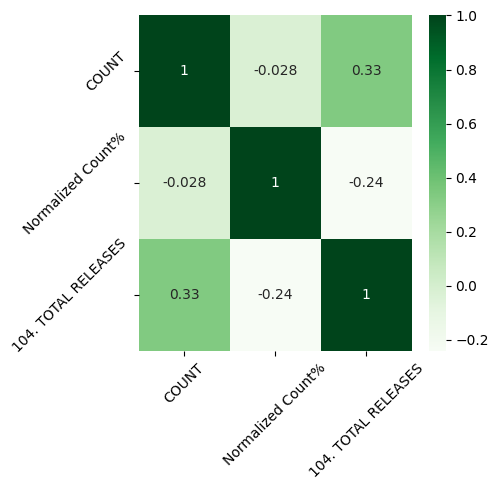

South


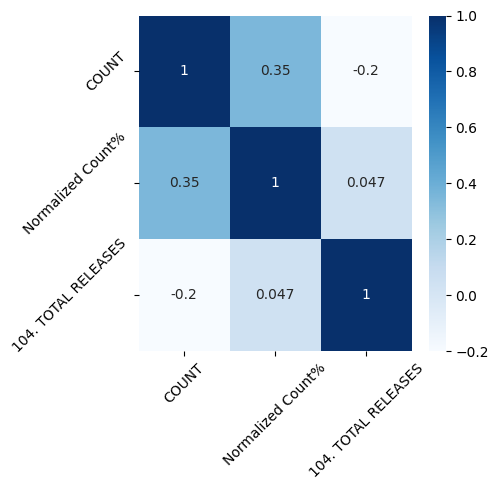

Alaska and Hawaii


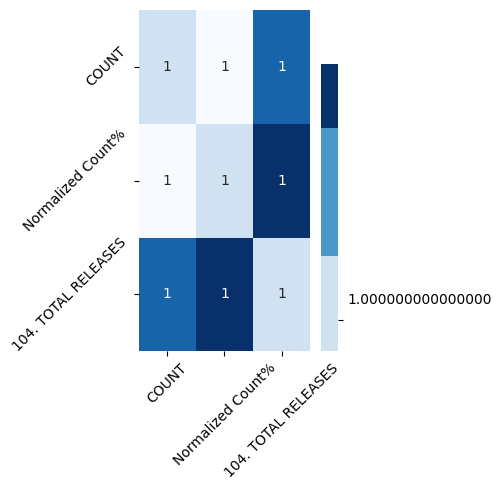

Southwest


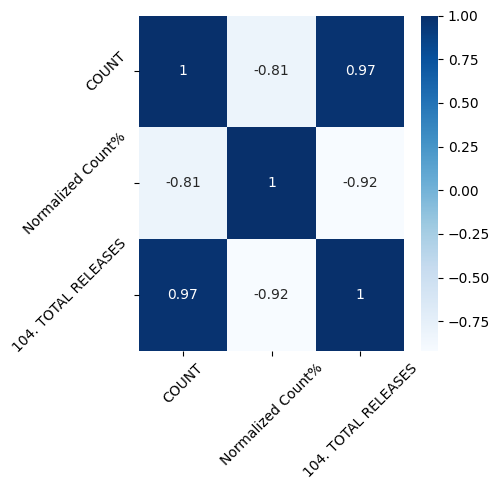

West Coast


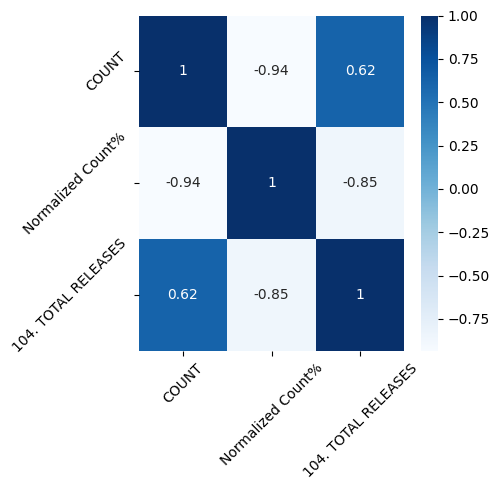

Rocky Mountains


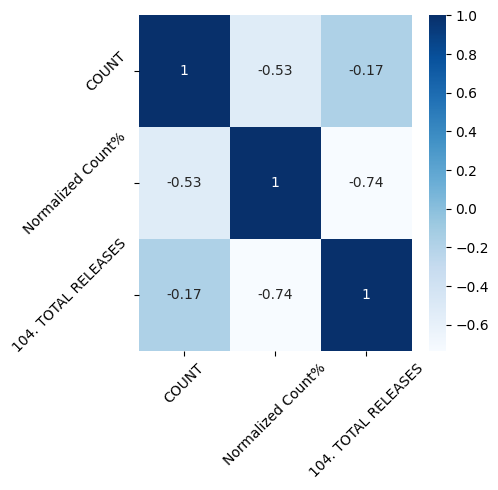

New England


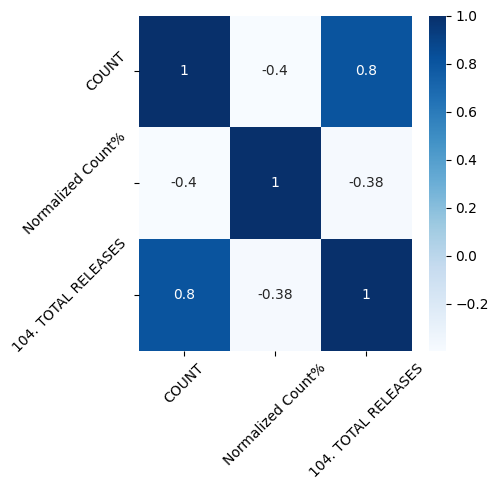

Mid-Atlantic


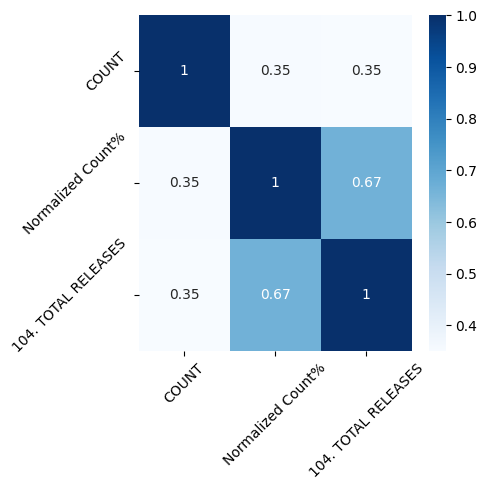

Midwest


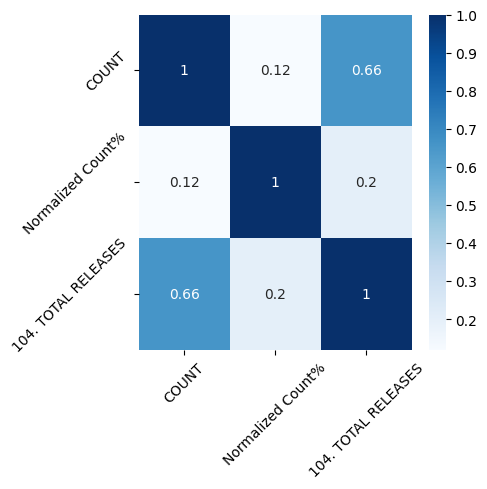

Great Plains


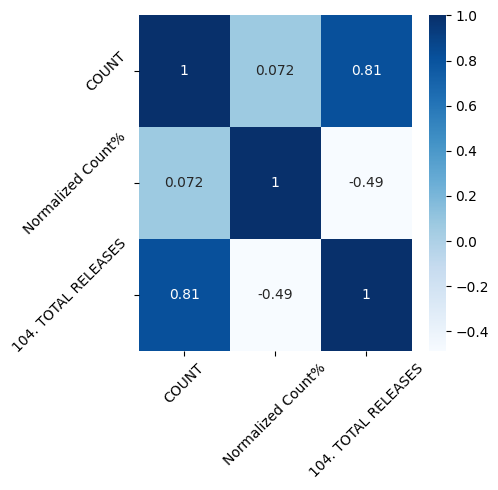

In [55]:
#importing modules
import pandas as pd
import csv
import seaborn as sns 
import matplotlib.pyplot as plt


#remove warnings
pd.set_option('mode.chained_assignment', None)

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION
data_path_chemicalpollution = '/kaggle/input/2020-chemical-pollutants-data/2020_us.csv'
data_path_states ='/kaggle/input/50-states-abbreviations/50States.csv'
data_path_cancercount = '/kaggle/input/cancer-by-area/BYAREA.csv.TXT'
data_path_differentRegions = '/kaggle/input/regions-to-state-mapping-usa/DifferentRegionsUSA.csv'
data_path_allsites = '/kaggle/input/all-cancer-sites/sites.csv'

year = '2020'
pollutant = 'Benzene'
#site_csv = 'df_cancer_leadpollution-brainandothernervoussystem.csv'

site = 'Pancreas' 
num1 = 0
num2 = 1000

########################################################
#STEP 1 - Create Chemical pollution dataset for USA states
########################################################
#converting into dataframe
df_cp = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_chemicalpollution))))

#get required columns
#print(len(df_cp.index))
#print(len(df_cp.columns))
#print((df_cp.columns))
chemical_pollution_df = df_cp.iloc[:, [7,33,42, 61, 84, 103, 104, 115]]
#print(chemical_pollution_df.columns)
chemical_pollution_df = chemical_pollution_df.loc[(chemical_pollution_df['34. CHEMICAL'] == pollutant)] 
#chemical_pollution_df = chemical_pollution_df.loc[(chemical_pollution_df['43. CARCINOGEN'] == 'YES') & (chemical_pollution_df['34. CHEMICAL'] == pollutant)] 
#print(len(chemical_pollution_df.index))

chemical_pollution_df['62. ON-SITE RELEASE TOTAL'] = chemical_pollution_df['62. ON-SITE RELEASE TOTAL'].astype('float')
chemical_pollution_df['85. OFF-SITE RELEASE TOTAL'] = chemical_pollution_df['85. OFF-SITE RELEASE TOTAL'].astype('float')
chemical_pollution_df['104. TOTAL RELEASES'] = chemical_pollution_df['104. TOTAL RELEASES'].astype('float')
chemical_pollution_df['105. 8.1 - RELEASES'] = chemical_pollution_df['105. 8.1 - RELEASES'].astype('float')
chemical_pollution_df['116. PRODUCTION WSTE (8.1-8.7)'] = chemical_pollution_df['116. PRODUCTION WSTE (8.1-8.7)'].astype('float')
#print(chemical_pollution_df.head)

chemical_pollution_df_new = chemical_pollution_df.iloc[:,[0,3,4,5,6,7]]
#print(chemical_pollution_df_new.head)
#print(chemical_pollution_df_new.columns)
chemical_pollution_df_final = chemical_pollution_df_new.groupby(['8. ST'], as_index=False).sum()
chemical_pollution_df_final = chemical_pollution_df_final.iloc[:,[0,1,2,3,4]]
chemical_pollution_df_final.rename(columns = {'8. ST':'AREA_abbr'}, inplace=True)

#print(chemical_pollution_df_final.columns)
#print(len(chemical_pollution_df_final.columns))
#print(chemical_pollution_df_final.head(1))
#print(chemical_pollution_df_final)
#print(len(chemical_pollution_df_final.index))

########################################################
#STEP 2 - Expanding the abbreviation of states
########################################################
df_states = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_states))))
df_states_final = df_states.iloc[:, [0,1]]
df_states_final.rename(columns = {'Abbr':'AREA_abbr'}, inplace=True)
df_states_final.rename(columns = {'State':'AREA'}, inplace=True)
df_states_final['AREA'] = df_states_final['AREA'].str.lower()
#print(df_states_final.columns)
#print(df_states_final)
df_all_cps = pd.merge(chemical_pollution_df_final, df_states_final, on='AREA_abbr', how='inner')
#print (df_all_cps)


########################################################
#STEP 3 - Create Cancer count dataset for USA states
##########################################################
#create dataframe
df_cc = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_cancercount))))

#Splitting the data into columns
df_new = df_cc.iloc[:, [0]]
df_new[['AREA','AGE_ADJUSTED_CI_LOWER', 'AGE_ADJUSTED_CI_UPPER','AGE_ADJUSTED_RATE','COUNT','EVENT_TYPE','POPULATION','RACE','SEX','SITE','YEAR','CRUDE_CI_LOWER','CRUDE_CI_UPPER','CRUDE_RATE']] = df_new['AREA|AGE_ADJUSTED_CI_LOWER|AGE_ADJUSTED_CI_UPPER|AGE_ADJUSTED_RATE|COUNT|EVENT_TYPE|POPULATION|RACE|SEX|SITE|YEAR|CRUDE_CI_LOWER|CRUDE_CI_UPPER|CRUDE_RATE'].str.split('|', expand=True)

#Clean the data to remove the rows where the values are not integers
if (site == 'all'):
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == 'All Cancer Sites Combined') & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 
else:
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == site) & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 

# #Seleting the columns needed
cancer_area = df_new.iloc[:, [1,5]]

# #Converting column to integer
#print(len(df_new))
cancer_area['COUNT'] = cancer_area['COUNT'].astype('int')
#print(cancer_area) 

########################################################
#STEP 4- Create dataset population per state
##########################################################
#Selecting the columns needed
cancer_area_population = df_new.iloc[:, [1,7]]

#Converting column to integer
cancer_area_population['POPULATION'] = cancer_area_population['POPULATION'].astype('int')
cancer_area_population = cancer_area_population.groupby(['AREA'], as_index=False).max()

########################################################
#STEP 5 - Merge datasets cancer_area_pollution, cancer_count, chemical_pollution_df_new
##########################################################
df_cancer_population_count = pd.merge(cancer_area, cancer_area_population, on='AREA', how='outer')

#Create additional column in the table for (Count/Population * 10000)
df_cancer_population_count['COUNT'] = df_cancer_population_count['COUNT'].astype('int')
df_cancer_population_count['POPULATION'] = df_cancer_population_count['POPULATION'].astype('int')
df_cancer_population_count['Normalized Count%'] = df_cancer_population_count['COUNT'] * 10000 / df_cancer_population_count['POPULATION']

df_cancer_population_count['AREA'] =  df_cancer_population_count['AREA'].str.lower()
#print (df_cancer_population_count)
#print (df_all_cps)

df_all = pd.merge(df_cancer_population_count, df_all_cps, on='AREA', how='inner')
#print(df_all)

########################################################
#STEP 6 - Check for correlation across USA
##########################################################
df_region_cancer = df_all.iloc[:,[1,3,7]]
print(df_region_cancer.columns)
matrix_normalized_test = df_region_cancer.corr()
#print (matrix_normalized_test)
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True
fig, (ax1) = plt.subplots(ncols=1)
fig.subplots_adjust(wspace=0.05)
sns.heatmap(matrix_normalized_test, cmap="Greens", ax=ax1, cbar=True, annot=True)
ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
fig.subplots_adjust(wspace=0.005)
plt.show()

########################################################
#STEP 6 - Add in different regions to meged table
##########################################################
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_differentRegions))))
df_ap['AREA'] =  df_ap['AREA'].str.lower()
df_cancercount_region = pd.merge(df_all, df_ap, on='AREA', how='outer' )
#print(df_cancercount_region)

########################################################
#STEP 7 - Check for correlation across different regions
##########################################################
regions = ["South","Alaska and Hawaii", "Southwest", "West Coast", "Rocky Mountains", "New England", "Mid-Atlantic", "Midwest", "Great Plains"]
for region in regions:
    #---Consider region create corelation matrix ----
    df_region = df_cancercount_region.loc[(df_cancercount_region['Region '] == region)] 
    print (region)
    df_region_cancer = df_region.iloc[:, [1,3,7]]
    #print (df_region_cancer)
    matrix_normalized_test = df_region_cancer.corr()
    plt.rcParams["figure.figsize"] = [5, 5]
    plt.rcParams["figure.autolayout"] = True
    fig, (ax1) = plt.subplots(ncols=1)
    sns.heatmap(matrix_normalized_test, cmap="Blues", ax=ax1, cbar=True, annot=True)
    ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
    ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
    fig.subplots_adjust(wspace=0.005)
    plt.show()

# ########################## METHOD END ################################

